# Investigate which distribution best fit yearly prices & Correlation 

In [37]:
import pandas as pd
import glob
import os
from distfit import distfit
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import stats
from scipy.stats import expon,t


# Read CSV and convert commas to dots for numeric columns
df = pd.read_csv("EnergyReport.csv", sep=";", decimal=",")
df = df.drop(columns=['HourDK'])
df.index = pd.to_datetime(df["HourUTC"])
df = df.drop(columns=['HourUTC'])

In [38]:
df

,OnshoreWindGe50kW_MWhDK2,GrossConsumptionMWhDK2,DK2_EUR/MWh
HourUTC,,,
2019-12-31 23:00:00,229.717789,1410.602295,33.419998
2020-01-01 00:00:00,204.677185,1381.264282,31.770000
2020-01-01 01:00:00,214.743927,1340.298462,31.570000
2020-01-01 02:00:00,221.410843,1294.275391,31.280001
2020-01-01 03:00:00,238.787140,1254.853394,30.850000
...,...,...,...
2024-12-30 18:00:00,611.443579,2057.596875,33.000000
2024-12-30 19:00:00,613.892341,1937.079757,31.500000
2024-12-30 20:00:00,615.155000,1879.134644,31.410000


# Find Best Distribution for yearly prices

In [41]:
yearly_df = df.resample('Y').sum()
# Print statistics for each column
for column in yearly_df.columns:
    print(f"\n{column}:")
    print(f"Average: {yearly_df[column].mean():.2f}")
    print(f"Std Dev: {yearly_df[column].std():.2f}")


OnshoreWindGe50kW_MWhDK2:
Average: 1388214.99
Std Dev: 690091.27

GrossConsumptionMWhDK2:
Average: 11400944.88
Std Dev: 5597333.43

DK2_EUR/MWh:
Average: 699614.09
Std Dev: 633435.28


[04-06-2025 20:06:43] [distfit.distfit] [INFO] fit
[04-06-2025 20:06:43] [distfit.distfit] [INFO] transform
[04-06-2025 20:06:43] [distfit.distfit] [INFO] [norm      ] [0.00 sec] [RSS: 5.32671e-13] [loc=699614.092 scale=578244.654]
[04-06-2025 20:06:43] [distfit.distfit] [INFO] [expon     ] [0.00 sec] [RSS: 2.60817e-13] [loc=33.420 scale=699580.672]
[04-06-2025 20:06:43] [distfit.distfit] [INFO] [pareto    ] [0.00 sec] [RSS: 1.17827e-12] [loc=-1905.583 scale=1939.003]
[04-06-2025 20:06:43] [distfit.distfit] [INFO] [dweibull  ] [0.03 sec] [RSS: 6.78617e-13] [loc=711812.810 scale=400799.344]
[04-06-2025 20:06:43] [distfit.distfit] [INFO] [t         ] [0.14 sec] [RSS: 2.00304e-12] [loc=33.420 scale=0.000]
[04-06-2025 20:06:44] [distfit.distfit] [INFO] [genextreme] [0.12 sec] [RSS: 1.72664e-12] [loc=36.827 scale=24.393]
[04-06-2025 20:06:44] [distfit.distfit] [INFO] [gamma     ] [0.03 sec] [RSS: 1.12479e-12] [loc=33.420 scale=913671.330]
[04-06-2025 20:06:44] [distfit.distfit] [INFO] [logn

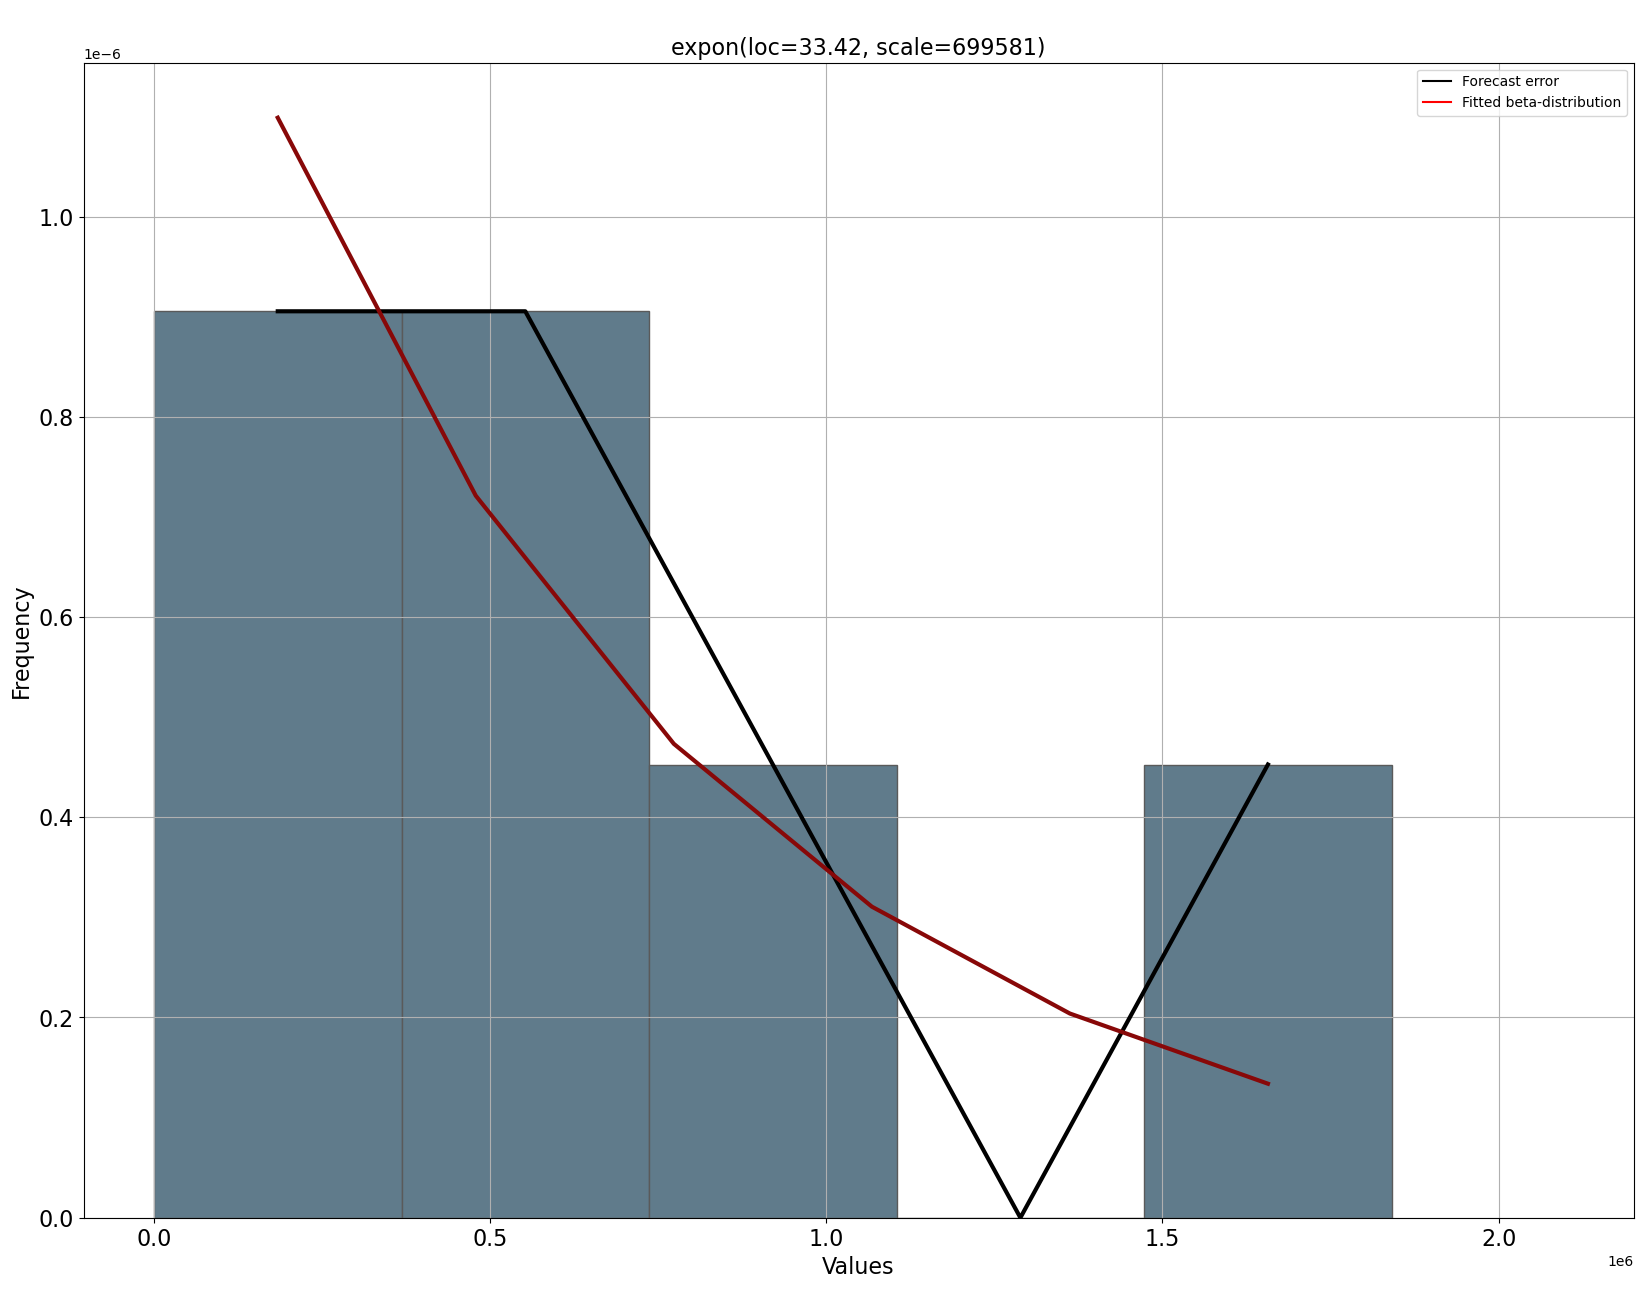

In [42]:
dist_yearly = distfit()
# Find best theoretical distribution for empirical data X
dist_yearly.fit_transform(yearly_df['DK2_EUR/MWh'])
fig, ax = dist_yearly.plot()
ax.lines[-1].remove()
ax.lines[-1].remove()
l1 = Line2D([0], [0], color='black', label="Forecast error")
l2 = Line2D([0], [0], color='red', label="Fitted beta-distribution")
handles = [l1, l2]
ax.legend(handles=handles)

In [43]:
# Fit t-distribution to the electricity data
data = df['OnshoreWindGe50kW_MWhDK2']  # your electricity data
df_freedom, loc, scale = t.fit(data)

# Generate samples
n_samples = 1000  # adjust number of samples as needed
samples = t.rvs(df=df_freedom, loc=loc, scale=scale, size=n_samples)

# Plot comparison of original data and samples

# Find Correlation between Onshore production and Energy Prices

In [57]:
df_corr = df
df_corr  = df.resample('H').sum()


# Mean and std for price 
price_mu, price_std = df_corr['DK2_EUR/MWh'].mean(), df_corr['DK2_EUR/MWh'].std() # EUR/MWh

# Mean and std for production
prod_mu, prod_std = df_corr['OnshoreWindGe50kW_MWhDK2'].mean(), df_corr['OnshoreWindGe50kW_MWhDK2'].std() # MWh

corr = df_corr['DK2_EUR/MWh'].corr(df_corr['OnshoreWindGe50kW_MWhDK2'])


CR = 1 + corr * (prod_std / prod_mu) * (price_std / price_mu)
print(f"\nCorrelation between price and production: {corr:.2f}")
print(f"Capture Rate : {CR:.2f}")


Correlation between price and production: -0.33
Capture Rate : 0.69


In [63]:
import numpy as np

In [47]:
import numpy as np
noise = np.random.normal(0,1,100)

CR_arr = (1 + (corr+noise) * (prod_std / prod_mu) * (price_std / price_mu))
CR_arr = np.clip(CR_arr, -1, 1)  # Ensure CR is non-negative

# Verify bounds
print(f"Min correlation: {CR_arr.min():.3f}")
print(f"Max correlation: {CR_arr.max():.3f}")
print(f"Mean correlation: {CR_arr.mean():.3f}")

Min correlation: -1.000
Max correlation: 1.000
Mean correlation: 0.422


# Load Profile 